# Student Names
-----

**Names: Tomas Woldu, Tsvetomira Krikoryan, Erik Frohn**

**sNumbers: s1024181, s1051145, s1034685**

-----

# Preprocessing Dataset

In [1]:
import numpy as np
import torch
import pandas as pd
from torch import nn

# Helper function to parse each line
def parse_line(line):
    elements = line.split()
    label = int(elements[0])
    qid = int(elements[1].split(':')[1])
    features = {int(f.split(':')[0]): float(f.split(':')[1]) for f in elements[2:]}  # Dictionary comprehension
    features[701] = label                                                            #Number of features = 700
    features[-2] = qid
    return features

common_path = 'dataset/Learning to Rank Challenge/ltrc_yahoo'
train = common_path + '/set2.train.txt'
test = common_path +  '/set2.test.txt'
valid = common_path + '/set2.valid.txt'

file_paths = {"train":train, "test":test, "valid":valid}

dfs = {}
for filename in file_paths:
    file = open(file_paths[filename], 'r')
    parsed_lines = list(map(parse_line, file.readlines()))
    dfs[filename] = pd.DataFrame(parsed_lines)
    file.close()

In [2]:
def replace_nan(df):
    replacement_dic = {}
    for col in df.columns:
        if col > 0: # replace only NaN values in the feature columns
            replacement_dic[col] = 0 #df[col].mean()
    df.fillna(replacement_dic, inplace=True)


df_train= dfs['train']
df_test= dfs['test']
df_valid= dfs['valid']

unique_train = df_train.columns.difference(df_test.columns)
unique_valid = df_valid.columns.difference(df_valid.columns)
unique_test = df_test.columns.difference(df_train.columns)

# Add missing columns
for col in unique_test:
    df_train[col]=0
    df_valid[col]=0

#sort so labels are at the end
df_train_o = df_train.sort_index(axis=1)
df_valid_o = df_valid.sort_index(axis=1)
df_test_o = df_test.sort_index(axis=1)

print(df_train_o.shape, df_test_o.shape, df_valid_o.shape)

# drop qids
df_train = df_train_o.drop(columns=[-2], inplace=False)
df_test = df_test_o.drop(columns=[-2], inplace=False)
df_valid = df_valid_o.drop(columns=[-2], inplace=False)

# Replace nans
replace_nan(df_train)
replace_nan(df_valid)
replace_nan(df_test)

train_tensor = torch.tensor(df_train.values)
valid_tensor = torch.tensor(df_valid.values)
test_tensor = torch.tensor(df_test.values)

# Sanity check
assert(train_tensor.shape == torch.Size([34815, 596]))
assert(test_tensor.shape == torch.Size([103174, 596]))
assert(valid_tensor.shape == torch.Size([34881, 596]))
# No-nan values check
assert(torch.any(torch.isnan(train_tensor)).item() == False)
assert(torch.any(torch.isnan(test_tensor)).item() == False)
assert(torch.any(torch.isnan(valid_tensor)).item() == False)

print(train_tensor.shape)
print(test_tensor.shape)
print(valid_tensor.shape)

(34815, 597) (103174, 597) (34881, 597)
torch.Size([34815, 596])
torch.Size([103174, 596])
torch.Size([34881, 596])


# Class Imbalance

[]

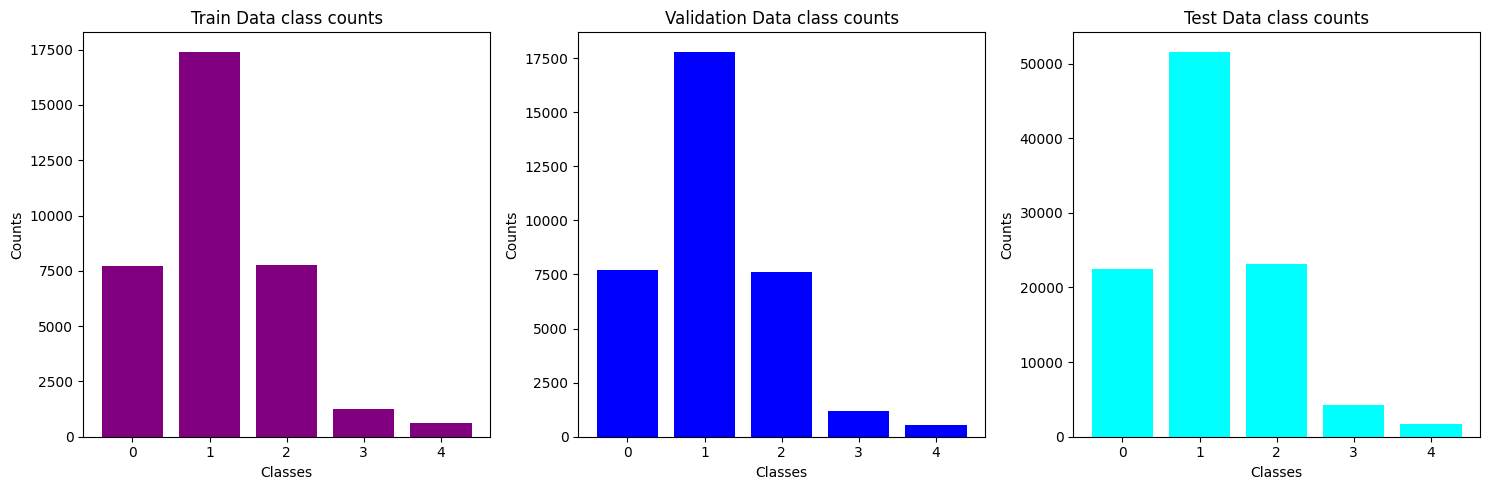

In [3]:
import matplotlib.pyplot as plt
import numpy as np


class_counts_train = df_train[701].value_counts()
class_counts_valid = df_valid[701].value_counts()
class_counts_test = df_test[701].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(class_counts_train.index, class_counts_train.values, color='purple')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Counts')
axes[0].set_title('Train Data class counts')

axes[1].bar(class_counts_valid.index, class_counts_valid.values, color='blue')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Counts')
axes[1].set_title('Validation Data class counts')

axes[2].bar(class_counts_test.index, class_counts_test.values, color='cyan')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Counts')
axes[2].set_title('Test Data class counts')

plt.tight_layout()
plt.plot()

# Sample using SMOTE

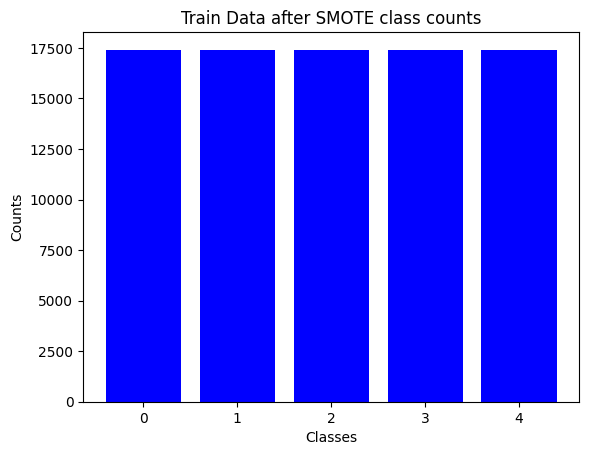

In [4]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=37)
X_train, y_train = train_tensor[:, :-1].numpy(), train_tensor[:, -1].numpy()
X_train_new, y_train_new = smote.fit_resample(X_train, y_train)
X_train_new, y_train_new = torch.from_numpy(X_train_new), torch.from_numpy(y_train_new)
train_tensor = torch.cat((X_train_new, y_train_new.unsqueeze(1)), dim=1)

dic = Counter(train_tensor[:, -1].numpy())
fig, ax = plt.subplots()
ax.bar(dic.keys(), dic.values(), color='blue')
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Train Data after SMOTE class counts')

plt.show()

# DataLoader

In [5]:
from torch.utils.data import Dataset, DataLoader 

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.label = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return {"data": self.data[idx].to(torch.float32), "label":self.label[idx].to(torch.long)}

train_iter = DataLoader(CustomDataset(train_tensor[:, :-1], train_tensor[:, -1]), shuffle=True, batch_size=128)
valid_iter = DataLoader(CustomDataset(valid_tensor[:, :-1], valid_tensor[:, -1]), shuffle=True, batch_size=128)
test_iter = DataLoader(CustomDataset(test_tensor[:, :-1], test_tensor[:, -1]), batch_size=128)

data_iter = {"train" : train_iter, "valid" : valid_iter}
# compute class weights to account for class imbalance
class_counts = torch.bincount(train_tensor[:, -1].to(torch.int64))
total_samples = len(train_tensor[:, -1])
class_weights = total_samples / (len(class_counts) * class_counts.float())

# Fully Connected Neural Network

In [6]:
import matplotlib.pyplot as plt

class Network(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 150), nn.ReLU(),
            nn.Linear(150, 75), nn.ReLU(),
            nn.Linear(75, num_classes)
        )
    def forward(self, x):
        return self.layers(x)


def train(network, num_epochs=10, lr=1e-3, verbose=False):
    optimizer = torch.optim.Adam(network.parameters(),   lr=lr)
    loss_funtion = torch.nn.CrossEntropyLoss()
    train_loss, train_accuracy, valid_loss, valid_accuracy = [], [], [], [] 
    for i in range(num_epochs):
        for phase in ["train", "valid"]:
            total_loss , total_accuracy, steps = 0, 0, 0
            if phase == "train":
                network.train()
            else:
                network.eval()
            for batch in data_iter[phase]:
                optimizer.zero_grad()
                x, y = batch["data"], batch["label"]
                y_hat = network(x)
                loss = loss_funtion(y_hat, y)
                y_hat = torch.argmax(network(x), dim=1)
                accuracy = torch.mean((y_hat == y).to(float))
                loss.backward()
                optimizer.step()
                total_loss += loss.detach().cpu().numpy()
                total_accuracy += accuracy.detach().cpu().numpy()
                steps+=1
            if phase == 'train':
                train_loss.append(total_loss / steps)
                train_accuracy.append(total_accuracy / steps)
            else:
                valid_loss.append(total_loss / steps)
                valid_accuracy.append(total_accuracy / steps)
        if verbose:
            print(f"epoch:{i+1} train_loss:{train_loss[-1]} train_accuracy:{train_accuracy[-1]} valid_loss:{valid_loss[-1]} valid_accuracy:{valid_accuracy[-1]}")
    plot(num_epochs, train_loss, train_accuracy, valid_loss, valid_accuracy)
    


def plot(num_epochs, train_loss, train_accuracy, valid_loss, valid_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    x = list(range(num_epochs))
    ax[0].plot(x, train_loss, label='train loss', color='red', linestyle='-', linewidth=2)
    ax[0].plot(x, valid_loss, label='valid loss', color='green', linestyle='-', linewidth=2)
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("loss")
    ax[0].set_title("Loss as a function of epochs")
    ax[0].legend()
    
    ax[1].plot(x, train_accuracy, label='train accuracy', color='blue', linestyle='--', linewidth=2)
    ax[1].plot(x, valid_accuracy, label='valid accuracy', color='black', linestyle='--', linewidth=2)
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("accuracy")
    ax[1].set_title("Accuracy as a function of epochs")
    ax[1].legend()
    
    #ax.set_xlabel("Epochs")
    #ax.set_ylabel("loss/accuracy")
    #ax.set_title("Graphs")
    #ax.legend()
    plt.tight_layout()
    plt.show()


epoch:1 train_loss:1.003865617399874 train_accuracy:0.5718153450807636 valid_loss:0.916439644146315 valid_accuracy:0.6072533636235559
epoch:2 train_loss:0.8054645062368172 train_accuracy:0.6585306534508076 valid_loss:0.9006126887632377 valid_accuracy:0.6123159692871232
epoch:3 train_loss:0.7140443945596222 train_accuracy:0.6973637114537445 valid_loss:0.8943901649324886 valid_accuracy:0.6184167194984503
epoch:4 train_loss:0.6566394219139424 train_accuracy:0.7221916299559471 valid_loss:0.8845685305612865 valid_accuracy:0.6200738764440688
epoch:5 train_loss:0.6132999488785753 train_accuracy:0.7404093245227606 valid_loss:0.8855911809882838 valid_accuracy:0.6210459812623274
epoch:6 train_loss:0.5780065755049387 train_accuracy:0.7556442731277533 valid_loss:0.8715844907603421 valid_accuracy:0.6251730240912933
epoch:7 train_loss:0.5515477031513107 train_accuracy:0.7676027900146842 valid_loss:0.8658170250309256 valid_accuracy:0.6295113940546633
epoch:8 train_loss:0.5289580367735304 train_accura

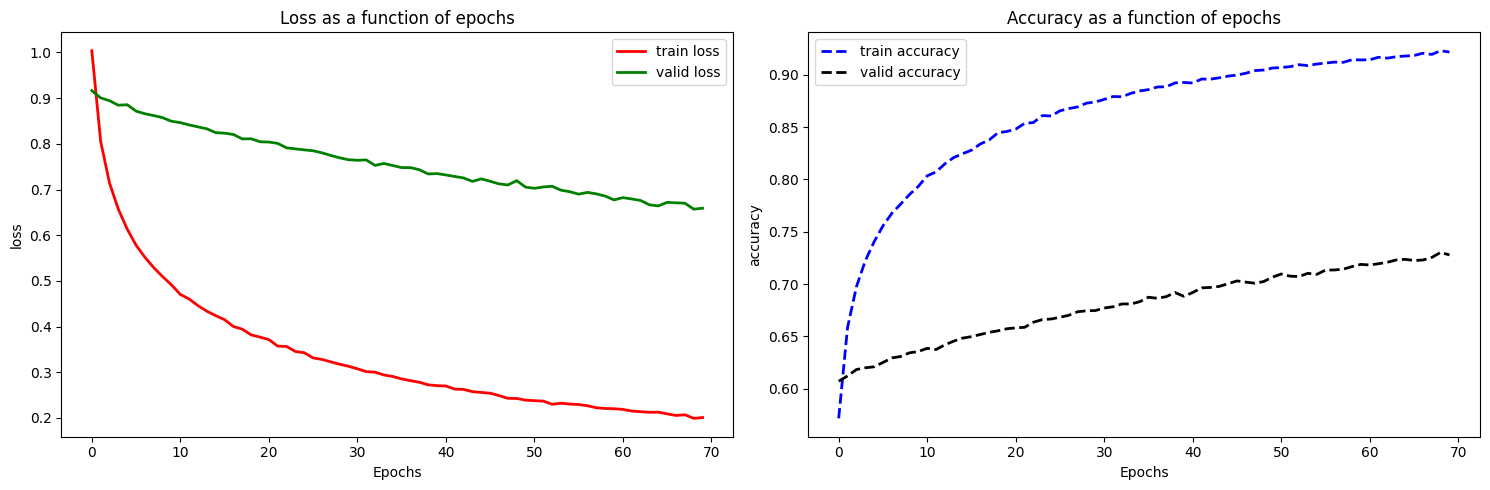

In [7]:
# Train the network and see the results
network = Network(595, 5)
train(network, num_epochs=70, verbose=True, lr=1e-3)

# Run model on unseen test set

In [8]:
# Run the model
network.eval()
y_pred = network(test_tensor[:, :-1].to(torch.float32))
y_pred = torch.argmax(y_pred, dim=1).numpy()

# Implementation of the Evaluation metrics

In [9]:
# Yahoo implementation of ndcg dcg and err scores
import numpy as np

def dcg_score(y_true, y_hat, k):
    # compute the limit 
    limit = min(k, len(y_true[0]))
    # get the indices of the ranking
    ordered_pred = np.argsort(y_hat)[:, ::-1]
    # use the indices to compute the new ranking of  the documents
    ranking = np.zeros_like(y_true)
    for i in range(y_true.shape[0]):
        ranking[i]=y_true[i][ordered_pred]
    # get the top k/limit documents
    ranking = ranking[:, :limit]
    # compute dcg score
    dcg = (2 ** ranking - 1) / np.log2(np.arange(2, limit+2))
    return np.sum(dcg, axis=1)


def ndcg_score(y_true, y_hat, k):
    # get the dcg score
    dcg = dcg_score(y_true, y_hat, k)
    # compute the ideal dcg score
    idcg = dcg_score(y_true, y_true, k)
    return 0 if idcg <=0 else dcg[0] / idcg[0]


def err_score(y_true, y_hat):
    # get the indices of the ranking
    ordered_pred = np.argsort(y_hat)[:, ::-1]
    # use the indices to compute the new ranking of  the documents
    ranking = np.zeros_like(y_true)
    for i in range(y_true.shape[0]):
        ranking[i]=y_true[i][ordered_pred]
    # compute err 
    err =0
    ranking = (2 ** ranking - 1) / 16
    ranking = ranking[0]
    for i in range(ranking.shape[0]):
        err += 1/(i+1) * ranking[i] * np.prod(1 - ranking[:i])
    return err

# Example runs   
true = np.array([[2, 1, 0, 3, 4]])
pr = np.array([[0, 1, 1, 1, 3]])
print(ndcg_score(true, pr, 3))
print(err_score(true, pr))

0.9282863095370069
0.9529571533203125


# Calculate NDCG & ERR metrics per query and then average it

In [10]:
# add prediction by the neural network

def calculate_metrics(y_pred):
    df_test_copy = df_test.copy(deep=True)
    df_test_copy["predictions"] = y_pred
    df_test_copy[-2] = df_test_o[-2]
    group_by_qid = df_test_copy.groupby(-2) 
    ndcg_scores = []
    err_scores = []
    skipped_qids = 0
    
    for _, group in group_by_qid:
        # Extract true relevance scores
        y_true = group[701].values.reshape(1, -1)
        y_hat = group["predictions"].values.reshape(1, -1)
        # skip if only one document for the given query
        if len(y_true[0]) == 1:
            skipped_qids+=1
            continue
        ndcg = ndcg_score(y_true, y_hat, k=10)  # Use y_true as y_score for simplicity
        err = err_score(y_true, y_hat)
        ndcg_scores.append(ndcg)
        err_scores.append(err)
    mean_ndcg = sum(ndcg_scores) / len(ndcg_scores)
    mean_err = sum(err_scores) / len(err_scores)
    return mean_ndcg, mean_err, skipped_qids

mean_ndcg, mean_err, skipped_qids = calculate_metrics(y_pred)
#mean_ndcg = sum(ndcg_scores) / len(ndcg_scores)
#mean_err = sum(err_scores) / len(err_scores)
print(f"Mean NDCG scores: {mean_ndcg}")
print(f"Mean ERR scores: {mean_err}")
print(f'Number of queries with just one document {skipped_qids}')

Mean NDCG scores: 0.6638119234672497
Mean ERR scores: 0.39503135700085845
Number of queries with just one document 17


# Light Gradient Boosted

In [20]:
import pandas as pd
import lightgbm as lgbm

# Calculate the ndcg for lgbm
def ndcg_lgbm(y_true, y_preds):
    metric = ndcg_score(y_true[None, :], y_preds[None, :], 10)
    return 'ndcg_lgbm', metric, False

# Function to calculate the group sizes
def get_query_groups(df, qid_column):
    return df.groupby(qid_column).size().tolist()

# Spliting data to features and label 
X_train, y_train = df_train.drop(columns=[701], inplace=False), df_train[701]
X_valid, y_valid = df_valid.drop(columns=[701], inplace=False), df_valid[701]
X_test, y_test = df_test.drop(columns=[701], inplace=False), df_test[701]


# Calculate group sizes for each set
query_train = get_query_groups(df_train_o, -2)
query_valid = get_query_groups(df_valid_o, -2)
query_test = get_query_groups(df_test_o, -2)


# Make LGBM dataset
train_data = lgbm.Dataset(X_train, label=y_train, group=query_train)
valid_data = lgbm.Dataset(X_valid, label=y_valid, reference=train_data, group=query_valid)


params = {
    'objective' : 'rank_xendcg',
    'boosting_type' : 'gbdt',
    'learning_rate' : '1e-2',
    'num_trees' : 2400,
    'feature_fraction' : 0.8
}

model = lgbm.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[valid_data],
    feval= lambda y_pred, eval_dataset : ndcg_lgbm(eval_dataset.get_label(), y_pred),
    callbacks=[lgbm.early_stopping(100, first_metric_only=True)]
)

predictions = model.predict(X_test, num_iteration=model.best_iteration)

lgbm_mean_ndcg, lgbm_mean_err, lgbm_skipped_qids = calculate_metrics(predictions)
print(f"Mean NDCG scores: {lgbm_mean_ndcg}")
print(f"Mean ERR scores: {lgbm_mean_err}")
print(f'Number of queries with just one document {lgbm_skipped_qids}')


/home/tomas/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76133
[LightGBM] [Info] Number of data points in the train set: 34815, number of used features: 570
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1035]	valid_0's ndcg@1: 0.753148	valid_0's ndcg@2: 0.734951	valid_0's ndcg@3: 0.733818	valid_0's ndcg@4: 0.73621	valid_0's ndcg@5: 0.740629	valid_0's ndcg_lgbm: 0.923843
Evaluated only: ndcg@1
Mean NDCG scores: 0.7579893485766324
Mean ERR scores: 0.4612107465415814
Number of queries with just one document 17


# Random Forest Regressor Training

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=37)

# Fit the model to the imputed data
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [22]:
# Generate predictions
rf_predictions = rf_model.predict(X_test)
rf_mean_ndcg, rf_mean_err, rf_skipped_qids = calculate_metrics(rf_predictions)

print(f"Mean NDCG scores: {rf_mean_ndcg}")
print(f"Mean ERR scores: {rf_mean_err}")
print(f'Number of queries with just one document {lgbm_skipped_qids}')

Mean NDCG scores: 0.7564897293293784
Mean ERR scores: 0.46067598926911235
Number of queries with just one document 17
